# Plot Curvature of a Variety of *Biologically Inspired* Models

In [1]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from utils_henaff import *
#import timm
import torchvision
import torchvision.models as models
from torchvision import transforms
import os
import sys

%load_ext autoreload
from fast_curvature import *

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# setting path
sys.path.append('../../straightening_models/vonenet/')
sys.path.append('../../straightening_models_code/vonenet/')
import vonenet as vonenet

## Video

In [2]:
vid = load_all_henaff_videos_corrected(img_size=224,rgb=True,imagenet=False)
videos = [vid['natural'].float().contiguous().to(device),
          vid['contrast'].float().contiguous().to(device), 
          vid['artificial'].float().contiguous().to(device)]

natural
contrast


/data1/groups/RosenholtzLab/PredStraightening/Henaff_straightening/utilities.py:73: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1055.)
  x[i].copy_( imgA ).mul_( 1-t ).add_( t, imgB )


artificial


## VOneNet ResNet50

In [3]:
## VOneNet ResNet50
model_arch = 'resnet50'
model = vonenet.get_model(model_arch=model_arch, pretrained=True)
model = model.to(device)

model.eval()

Neuronal distributions gabor parameters


/data1/groups/RosenholtzLab/PredStraightening/Henaff_straightening/../../straightening_models_code/vonenet/vonenet/params.py:59: RuntimeWarning: invalid value encountered in true_divide
  ny_dist_marg = n_joint_dist / n_joint_dist.sum(axis=1, keepdims=True)
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Model:  VOneResnet50


In [4]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Total params: ', pytorch_total_params)

Total params:  25580264


In [5]:
model.module.vone_block

VOneBlock(
  (simple_conv_q0): GFB()
  (simple_conv_q1): GFB()
  (simple): ReLU(inplace=True)
  (complex): Identity()
  (gabors): Identity()
  (noise): ReLU(inplace=True)
  (output): Identity()
)

In [5]:
model_blocks = [model.module.vone_block.simple_conv_q0,
                model.module.vone_block.simple_conv_q1,
                model.module.vone_block.simple,
                model.module.vone_block.noise,
                model.module.vone_block.output,
                model.module.bottleneck,
                model.module.model.layer1,
                model.module.model.layer2,
                model.module.model.layer3,
                model.module.model.layer4,
                model.module.model.avgpool,
                model.module.model.fc,
               ]

In [6]:
curvs_natural = get_intermediate_curv(model, model_blocks,videos[0])
curvs_contrast = get_intermediate_curv(model, model_blocks,videos[1])
curvs_artificial = get_intermediate_curv(model, model_blocks,videos[2])

mean_natural = curvs_natural.mean(0)
mean_contrast = curvs_contrast.mean(0)
mean_artificial = curvs_artificial.mean(0)

ste_natural = curvs_natural.std(0)/curvs_natural.size(0)**0.5
ste_contrast = curvs_contrast.std(0)/curvs_contrast.size(0)**0.5
ste_artificial = curvs_artificial.std(0)/curvs_artificial.size(0)**0.5

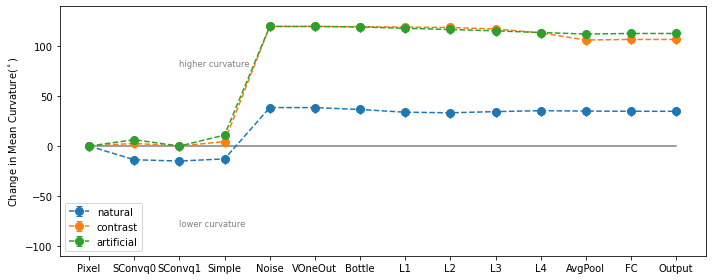

In [7]:
natural_plot = mean_natural - mean_natural[0].repeat(mean_natural.size(0))
contrast_plot = mean_contrast - mean_contrast[0].repeat(mean_contrast.size(0))
artificial_plot = mean_artificial - mean_artificial[0].repeat(mean_artificial.size(0))

xlabels = ['Pixel', 'SConvq0', 'SConvq1', 'Simple','Noise','VOneOut','Bottle','L1','L2','L3','L4','AvgPool','FC','Output']
output_dir = './vonenet_curves'
os.makedirs(output_dir,exist_ok=True)

all_curves = {'layer_names':xlabels,'natural_curves':mean_natural, 'contrast_curves':mean_contrast,'artificial_curves':mean_artificial,
              'natural_ste':ste_natural, 'contrast_ste':ste_contrast,'artificial_ste':ste_artificial}

plt.figure(figsize=(10,4))
plt.errorbar(xlabels, natural_plot, yerr=ste_natural, marker = 'o', linestyle='--',markersize=8,label='natural',uplims=True, lolims=True)
plt.errorbar(xlabels, contrast_plot, yerr=ste_contrast, marker = 'o', linestyle='--',markersize=8,label='contrast',uplims=True, lolims=True)
plt.errorbar(xlabels, artificial_plot, yerr=ste_artificial, marker = 'o', linestyle='--',markersize=8,label='artificial',uplims=True, lolims=True)

plt.plot([xlabels[0], xlabels[-1]],[0,0], '-', color='gray')
plt.ylim([-110, 140])
plt.ylabel('Change in Mean Curvature($^\circ$)')
plt.text(xlabels[2], -80,'lower curvature', color='gray',fontsize='small')
plt.text(xlabels[2], 80,'higher curvature', color='gray',fontsize='small')
plt.legend(loc='lower left')
# plt.title('Change in Curvature Across Alexnet Blocks (with PCA)', fontsize=12)
plt.tight_layout()
name = f'vonenet_{model_arch}'
save_name = os.path.join(output_dir,f'{name}_curve_change.png')
plt.savefig(save_name,dpi=300)
write_model_csv(output_dir, name, all_curves)

## VOneNet AlexNet

In [9]:
model_arch = 'alexnet'
model = vonenet.get_model(model_arch=model_arch, pretrained=True)
model = model.to(device)

model.eval();

Neuronal distributions gabor parameters
Model:  VOneAlexNet


/data1/groups/RosenholtzLab/PredStraightening/Henaff_straightening/../../straightening_models_code/vonenet/vonenet/params.py:59: RuntimeWarning: invalid value encountered in true_divide
  ny_dist_marg = n_joint_dist / n_joint_dist.sum(axis=1, keepdims=True)


In [10]:
model.module.vone_block

VOneBlock(
  (simple_conv_q0): GFB()
  (simple_conv_q1): GFB()
  (simple): ReLU(inplace=True)
  (complex): Identity()
  (gabors): Identity()
  (noise): ReLU(inplace=True)
  (output): Identity()
)

In [11]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Total params: ', pytorch_total_params)

Total params:  74741800


In [12]:
model_blocks = [model.module.vone_block.simple_conv_q0,
                model.module.vone_block.simple_conv_q1,
                model.module.vone_block.simple,
                model.module.vone_block.noise,
                model.module.vone_block.output,
                model.module.bottleneck,
                model.module.model.features[2],
                model.module.model.features[9],
                model.module.model.avgpool,
                model.module.model.classifier,
               ]

In [13]:
curvs_natural = get_intermediate_curv(model, model_blocks,videos[0])
curvs_contrast = get_intermediate_curv(model, model_blocks,videos[1])
curvs_artificial = get_intermediate_curv(model, model_blocks,videos[2])

mean_natural = curvs_natural.mean(0)
mean_contrast = curvs_contrast.mean(0)
mean_artificial = curvs_artificial.mean(0)

ste_natural = curvs_natural.std(0)/curvs_natural.size(0)**0.5
ste_contrast = curvs_contrast.std(0)/curvs_contrast.size(0)**0.5
ste_artificial = curvs_artificial.std(0)/curvs_artificial.size(0)**0.5

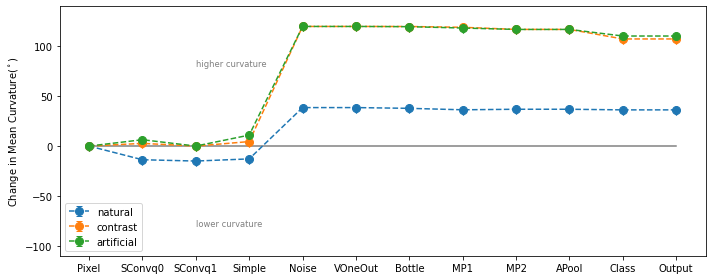

In [14]:
natural_plot = mean_natural - mean_natural[0].repeat(mean_natural.size(0))
contrast_plot = mean_contrast - mean_contrast[0].repeat(mean_contrast.size(0))
artificial_plot = mean_artificial - mean_artificial[0].repeat(mean_artificial.size(0))

xlabels = ['Pixel', 'SConvq0', 'SConvq1', 'Simple','Noise','VOneOut','Bottle','MP1','MP2','APool','Class','Output']
output_dir = './vonenet_curves'
os.makedirs(output_dir,exist_ok=True)

all_curves = {'layer_names':xlabels,'natural_curves':mean_natural, 'contrast_curves':mean_contrast,'artificial_curves':mean_artificial,
              'natural_ste':ste_natural, 'contrast_ste':ste_contrast,'artificial_ste':ste_artificial}

plt.figure(figsize=(10,4))
plt.errorbar(xlabels, natural_plot, yerr=ste_natural, marker = 'o', linestyle='--',markersize=8,label='natural',uplims=True, lolims=True)
plt.errorbar(xlabels, contrast_plot, yerr=ste_contrast, marker = 'o', linestyle='--',markersize=8,label='contrast',uplims=True, lolims=True)
plt.errorbar(xlabels, artificial_plot, yerr=ste_artificial, marker = 'o', linestyle='--',markersize=8,label='artificial',uplims=True, lolims=True)

plt.plot([xlabels[0], xlabels[-1]],[0,0], '-', color='gray')
plt.ylim([-110, 140])
plt.ylabel('Change in Mean Curvature($^\circ$)')
plt.text(xlabels[2], -80,'lower curvature', color='gray',fontsize='small')
plt.text(xlabels[2], 80,'higher curvature', color='gray',fontsize='small')
plt.legend(loc='lower left')
# plt.title('Change in Curvature Across Alexnet Blocks (with PCA)', fontsize=12)
plt.tight_layout()
name = f'vonenet_{model_arch}'
save_name = os.path.join(output_dir,f'{name}_curve_change.png')
plt.savefig(save_name,dpi=300)
write_model_csv(output_dir, name, all_curves)

## VOneNet CorNet

In [15]:
model_arch = 'cornets'
model = vonenet.get_model(model_arch=model_arch, pretrained=True)
model = model.to(device)

model.eval();

Neuronal distributions gabor parameters
Model:  VOneCORnet-S


/data1/groups/RosenholtzLab/PredStraightening/Henaff_straightening/../../straightening_models_code/vonenet/vonenet/params.py:59: RuntimeWarning: invalid value encountered in true_divide
  ny_dist_marg = n_joint_dist / n_joint_dist.sum(axis=1, keepdims=True)


In [16]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Total params: ', pytorch_total_params)

Total params:  53402856


In [17]:
model.module.vone_block

VOneBlock(
  (simple_conv_q0): GFB()
  (simple_conv_q1): GFB()
  (simple): ReLU(inplace=True)
  (complex): Identity()
  (gabors): Identity()
  (noise): ReLU(inplace=True)
  (output): Identity()
)

In [18]:
model_blocks = [model.module.vone_block.simple_conv_q0,
                model.module.vone_block.simple_conv_q1,
                model.module.vone_block.simple,
                model.module.vone_block.noise,
                model.module.vone_block.output,
                model.module.bottleneck,
                model.module.model.V2,
                model.module.model.V4,
                model.module.model.IT,
                model.module.model.decoder,
               ]

In [19]:
curvs_natural = get_intermediate_curv(model, model_blocks,videos[0])
curvs_contrast = get_intermediate_curv(model, model_blocks,videos[1])
curvs_artificial = get_intermediate_curv(model, model_blocks,videos[2])

mean_natural = curvs_natural.mean(0)
mean_contrast = curvs_contrast.mean(0)
mean_artificial = curvs_artificial.mean(0)

ste_natural = curvs_natural.std(0)/curvs_natural.size(0)**0.5
ste_contrast = curvs_contrast.std(0)/curvs_contrast.size(0)**0.5
ste_artificial = curvs_artificial.std(0)/curvs_artificial.size(0)**0.5

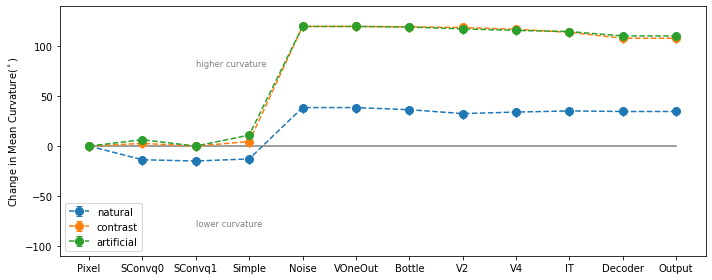

In [20]:
natural_plot = mean_natural - mean_natural[0].repeat(mean_natural.size(0))
contrast_plot = mean_contrast - mean_contrast[0].repeat(mean_contrast.size(0))
artificial_plot = mean_artificial - mean_artificial[0].repeat(mean_artificial.size(0))

xlabels = ['Pixel', 'SConvq0', 'SConvq1', 'Simple','Noise','VOneOut','Bottle','V2','V4','IT','Decoder','Output']
output_dir = './vonenet_curves'
os.makedirs(output_dir,exist_ok=True)

all_curves = {'layer_names':xlabels,'natural_curves':mean_natural, 'contrast_curves':mean_contrast,'artificial_curves':mean_artificial,
              'natural_ste':ste_natural, 'contrast_ste':ste_contrast,'artificial_ste':ste_artificial}

plt.figure(figsize=(10,4))
plt.errorbar(xlabels, natural_plot, yerr=ste_natural, marker = 'o', linestyle='--',markersize=8,label='natural',uplims=True, lolims=True)
plt.errorbar(xlabels, contrast_plot, yerr=ste_contrast, marker = 'o', linestyle='--',markersize=8,label='contrast',uplims=True, lolims=True)
plt.errorbar(xlabels, artificial_plot, yerr=ste_artificial, marker = 'o', linestyle='--',markersize=8,label='artificial',uplims=True, lolims=True)

plt.plot([xlabels[0], xlabels[-1]],[0,0], '-', color='gray')
plt.ylim([-110, 140])
plt.ylabel('Change in Mean Curvature($^\circ$)')
plt.text(xlabels[2], -80,'lower curvature', color='gray',fontsize='small')
plt.text(xlabels[2], 80,'higher curvature', color='gray',fontsize='small')
plt.legend(loc='lower left')
# plt.title('Change in Curvature Across Alexnet Blocks (with PCA)', fontsize=12)
plt.tight_layout()
name = f'vonenet_{model_arch}'
save_name = os.path.join(output_dir,f'{name}_curve_change.png')
plt.savefig(save_name,dpi=300)
write_model_csv(output_dir, name, all_curves)